# Методы машинного обучения – Контрольная работа №7

# Автокодировщики

Импортируем нужные на этой лабораторной работе библиотеки:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import pandas as pd
import time
import sys

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import tensorflow as tf

2024-05-30 23:36:47.183412: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-30 23:36:47.188676: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-30 23:36:47.258196: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 23:36:49.957347: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Наборы данных MNIST и FASHION MNIST 

Используем в материалах этой лабораторной работы два набора данных:

- [MNIST Dataset](http://yann.lecun.com/exdb/mnist/)
- [Fashion MNIST @ Zalando](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/)

Эти наборы легко импортируются при помощи `keras` ([```tensorflow.keras.datasets```](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)).

In [2]:
from keras.datasets import mnist

(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = \
    mnist.load_data()

In [3]:
from keras.datasets import fashion_mnist

(fashion_x_train,fashion_y_train), (fashion_x_test,fashion_y_test) = \
    fashion_mnist.load_data()

## Логарифмическое правдоподобие профиля

Определим размерность латентного пространства при помощи метода PCA и правдоподобия профиля. Для вычисления логарифмического правдоподобия профиля будем использовать следующую функцию:

In [4]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from scipy.stats import multivariate_normal
import warnings
warnings.simplefilter("ignore", RuntimeWarning)  # for some NaN values

# Function to calculate log likelihood of PCA from eigenvalues

def log_likelihood(evals):

    Lmax = len(evals)
    ll = np.arange(0.0, Lmax)

    for L in range(Lmax):

        group1 = evals[0 : L + 1]  # Divide Eigenvalues in two groups
        group2 = evals[L + 1 : Lmax]

        mu1 = np.mean(group1)
        mu2 = np.mean(group2)

        sigma = (np.sum((group1 - mu1) ** 2) + np.sum((group2 - mu2) ** 2)) / Lmax

        ll_group1 = np.sum(multivariate_normal.logpdf(group1, mu1, sigma))
        ll_group2 = np.sum(multivariate_normal.logpdf(group2, mu2, sigma))

        ll[L] = ll_group1 + ll_group2 

    return ll

Используем небольшую часть набора `MNIST` для цифры 3:

In [5]:
mnist_x_train3 = mnist_x_train[mnist_y_train == 3]  # select images of digit '3'

n_images = 1000
train_images = mnist_x_train3[0:n_images, :, :]
n_samples, n_rows, n_cols = mnist_x_train3.shape
X = np.reshape(mnist_x_train3, (n_samples, n_rows * n_cols))

X_train = X[0 : int(n_images / 2), :]  # 500 images in train set
X_test = X[int(n_images / 2) :, :]  # 500 images in test set

Построим ошибку реконструкции для различного числа главных компонент: 

In [6]:
# Reconstruction error on MNIST vs number of latent dimensions used by PCA

X_rank = np.linalg.matrix_rank(X_train)
K_linspace = np.linspace(1, 0.75 * X_rank, 10, dtype=int)
Ks = np.unique(np.append([1, 5, 10, 20], K_linspace))

RMSE_train = np.arange(len(Ks))
RMSE_test = np.arange(len(Ks))

for index, K in enumerate(Ks):
    pca = PCA(n_components=K)

    Xtrain_transformed = pca.fit_transform(X_train)
    Xtrain_proj = pca.inverse_transform(Xtrain_transformed)
    RMSE_train[index] = mean_squared_error(X_train, Xtrain_proj, squared=False)

    Xtest_transformed = pca.transform(X_test)
    Xtest_proj = pca.inverse_transform(Xtest_transformed)
    RMSE_test[index] = mean_squared_error(X_test, Xtest_proj, squared=False)

/home/gmatiukhin/Study/year3/ml-methods/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/gmatiukhin/Study/year3/ml-methods/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/gmatiukhin/Study/year3/ml-methods/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/gmatiukhin/Study/year3/ml-methods/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: Futu

Построим логарифмическое правдоподобие профиля для различного числа главных компонент:

In [7]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [8]:
# profile log likelihood for PCA

n_samples, n_features = X_train.shape
Kmax = min(n_samples, n_features)

pca = PCA(n_components=Kmax)
X_transformed = pca.fit_transform(X_train)
evals = pca.explained_variance_  # eigenvalues in descending order

ll = log_likelihood(evals)

# Fraction of variance explained

fraction_var = np.cumsum(evals[0:50] / np.sum(evals))

Теперь выполним визуализацию ошибки реконструкции и логарифмического правдоподобия профиля для различного числа главных компонент:

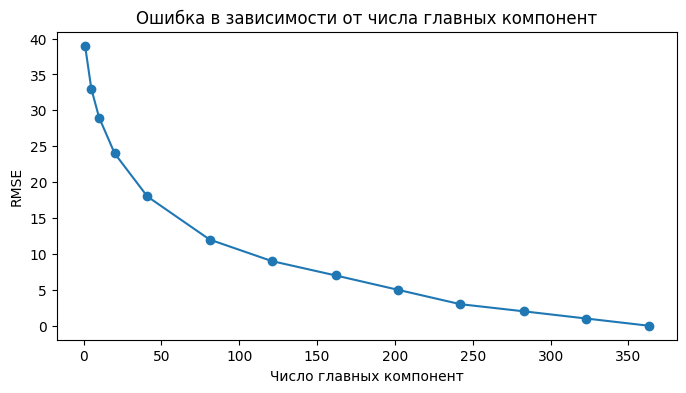

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
xs = Ks
ys = RMSE_train
plt.title("Ошибка в зависимости от числа главных компонент")
plt.xlabel("Число главных компонент")
plt.ylabel("RMSE")
ax.plot(xs, ys, marker="o")
plt.show()

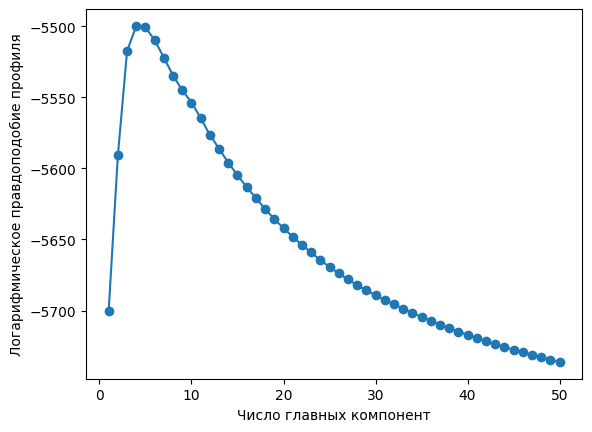

In [10]:
fig, ax = plt.subplots()
xs = np.arange(1, 51)
ys = ll[0:50]
plt.xlabel("Число главных компонент")
plt.ylabel("Логарифмическое правдоподобие профиля")

ax.plot(xs, ys, marker="o")
plt.show()

### Подготовка наборов данных для глубокого обучения

Как обычно, выполним типичную нормализацию наборов данных:

In [11]:
mnist_x_train = mnist_x_train.astype('float32') / 255.
mnist_x_test  = mnist_x_test.astype('float32') / 255.

fashion_x_train = fashion_x_train.astype('float32') / 255.
fashion_x_test  = fashion_x_test.astype('float32') / 255.

Создадим варианты наборов данных для обучения сетей MLP:

In [12]:
mnist_x_train.shape, mnist_x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [13]:
mnist_x_trainMLP = mnist_x_train.reshape(
    (len(mnist_x_train), np.prod(mnist_x_train.shape[1:])))
mnist_x_testMLP  = mnist_x_test.reshape(
    (len(mnist_x_test), np.prod(mnist_x_test.shape[1:])))
mnist_x_trainMLP.shape, mnist_x_testMLP.shape

((60000, 784), (10000, 784))

In [14]:
fashion_x_train.shape, fashion_x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [15]:
fashion_x_trainMLP = fashion_x_train.reshape(
    (len(fashion_x_train), np.prod(fashion_x_train.shape[1:])))
fashion_x_testMLP  = fashion_x_test.reshape(
    (len(fashion_x_test), np.prod(fashion_x_test.shape[1:])))
fashion_x_trainMLP.shape, fashion_x_testMLP.shape

((60000, 784), (10000, 784))

## Функция для создания автокодировщиков MLP

Автокодировщик состоит из двух частей: кодировщика (_encoder_) и декодера (_decoder_). Функция ```create_autoencoders()``` возвращает следующие объекты как отдельные модели:

- кодировщик 
- декодер
- полную модель, включающую кодировщик и декодер.

In [16]:
def create_autoencoders (feature_layer_dim = 16):
    input_img = Input(shape = (784,), name = 'Input_Layer')
    # Слой encoded имеет размерность, равную feature_layer_dim 
    # и содержит закодированные входные данные 
    encoded = Dense(feature_layer_dim, activation = 'relu', 
                    name = 'Encoded_Features')(input_img)
    decoded = Dense(784, activation = 'sigmoid', 
                    name = 'Decoded_Input')(encoded)

    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)

    encoded_input = Input(shape = (feature_layer_dim,))
    decoder = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder(encoded_input))

    return autoencoder, encoder, decoder

## Автокодировщик со слоями с $(784,16,784)$ нейронами

Начнем с автокодировщика, имеющего слои с размерностями $(784, 16, 784)$.




In [17]:
autoencoder16, encoder16, decoder16 = create_autoencoders(16)
autoencoder16.summary()
encoder16.summary()
decoder16.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoded_Features (Dense)        │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoded_Input (Dense)           │ (None, 784)            │        13,328 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,888 (101.12 KB)

 Trainable params: 25,888 (101.12 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoded_Features (Dense)        │ (None, 16)             │        12,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,560 (49.06 KB)

 Trainable params: 12,560 (49.06 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoded_Input (Dense)           │ (None, 784)            │        13,328 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,328 (52.06 KB)

 Trainable params: 13,328 (52.06 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
#keras.utils.plot_model(autoencoder16, show_shapes=True)

Теперь нужно скомпилировать модель и обучить ее на данных. Для работы с автоэнкодерами достаточно простой модели **создать** $\rightarrow$ **compile** $\rightarrow$ **fit**.

In [19]:
autoencoder16.compile(optimizer='adam', loss='binary_crossentropy')

In [20]:
history = autoencoder16.fit(mnist_x_trainMLP, mnist_x_trainMLP,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(mnist_x_testMLP, mnist_x_testMLP),
                verbose = 1);

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.4260 - val_loss: 0.2263
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2121 - val_loss: 0.1829
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1786 - val_loss: 0.1633
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1615 - val_loss: 0.1521
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1513 - val_loss: 0.1455
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1455 - val_loss: 0.1415
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1422 - val_loss: 0.1392
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1395 - val_loss: 0.1368
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1375 - val_loss: 0.1351
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1363 - val_loss: 0.1335
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1346 - val_loss: 0.1323
Epoch 12/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/ste

In [21]:
encoded_imgs = encoder16.predict(mnist_x_testMLP)
decoded_imgs = decoder16.predict(encoded_imgs)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


### Относительно сжатия

Поскольку мы сохранили и кодировщик, и декодер, мы можем создать закодированную версию изображений. Обратите внимание, что тип данных изображений — ```float32```. Каждый объект ```float32``` требует 4 байта. Исходные данные в ```mnist_x_test``` имеют вид ```(10000,784)```. Это означает, что пространство, необходимое для хранения этого массива, равно

$$
10000 \textrm{ изображений} \times 784 \textrm{ пикселей}\times 4 \textrm{ байт} = 29 \textrm{ Мб}
$$

Закодированные изображения требуют гораздо меньше места. На самом деле необходимый размер

$$
10000 \textrm{ изображений}\times 16 \textrm{ скрытых признаков}\times 4 \textrm{ байт} = 625 \textrm{ Кб}
$$

поэтому, если мы примем потерю качества в сжатых данных, мы получим невероятную степень сжатия около $46$. Эти размеры легко проверить, сохранив данные в файле и проверив размер файла. Обратите внимание, что размер файла будет больше, так как есть некоторая дополнительная информация, которую необходимо сохранить.

In [22]:
np.save('temp_orig', mnist_x_testMLP)
! ls -al temp_orig*

-rw-r--r-- 1 gmatiukhin gmatiukhin 31360128 May 30 23:38 temp_orig.npy


In [23]:
np.save('temp_encoded', encoded_imgs)
! ls -al temp_encoded*

-rw-r--r-- 1 gmatiukhin gmatiukhin 640128 May 30 23:38 temp_encoded.npy


## Анализ реконструированных изображений

Рассмотрим эффект от сжатия входных изображений. Наличие всего 16 нейронов в среднем слое дает следующий результат:

In [24]:
import matplotlib.pyplot as plt

def image_show(orig_imgs, dec_imgs, fname=None):
    n = 10  # кол-во изображений
    fig = plt.figure(figsize=(20, 4))
    for i in range(n):
        # исходные изображения
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(orig_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # реконструированные изображения
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(dec_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

    if fname:
        fig.savefig(fname)    

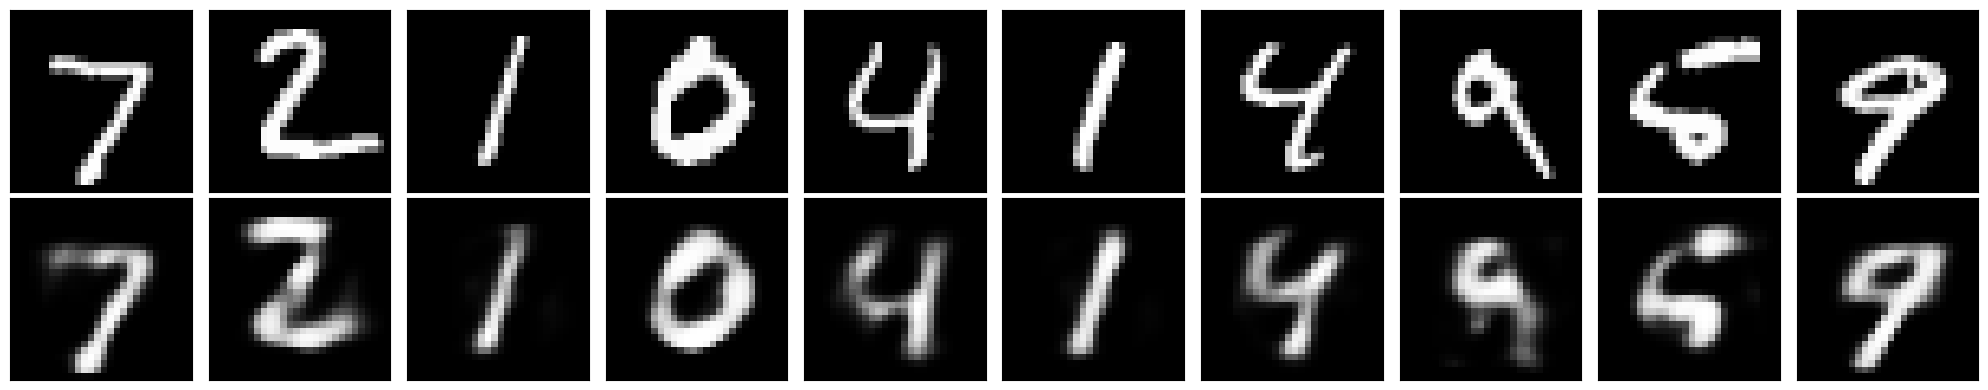

In [25]:
image_show(mnist_x_testMLP, decoded_imgs)

## Автокодировщик со слоями с $(784,64,784)$ нейронами


In [26]:
autoencoder64, encoder64, decoder64 = create_autoencoders(64)

In [27]:
autoencoder64.compile(optimizer='adam', loss='binary_crossentropy')

In [28]:
autoencoder64.fit(mnist_x_trainMLP, mnist_x_trainMLP,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(mnist_x_testMLP, mnist_x_testMLP),
                verbose = 1);

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.3493 - val_loss: 0.1620
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1521 - val_loss: 0.1262
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1228 - val_loss: 0.1088
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1072 - val_loss: 0.0977
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0967 - val_loss: 0.0903
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0898 - val_loss: 0.0850
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0850 - val_loss: 0.0817
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0817 - val_loss: 0.0792
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0795 - val_loss: 0.0775
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0781 - val_loss: 0.0764
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0769 - val_loss: 0.0755
Epoch 12/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s

In [29]:
encoded_imgs = encoder64.predict(mnist_x_testMLP)
decoded_imgs = decoder64.predict(encoded_imgs)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


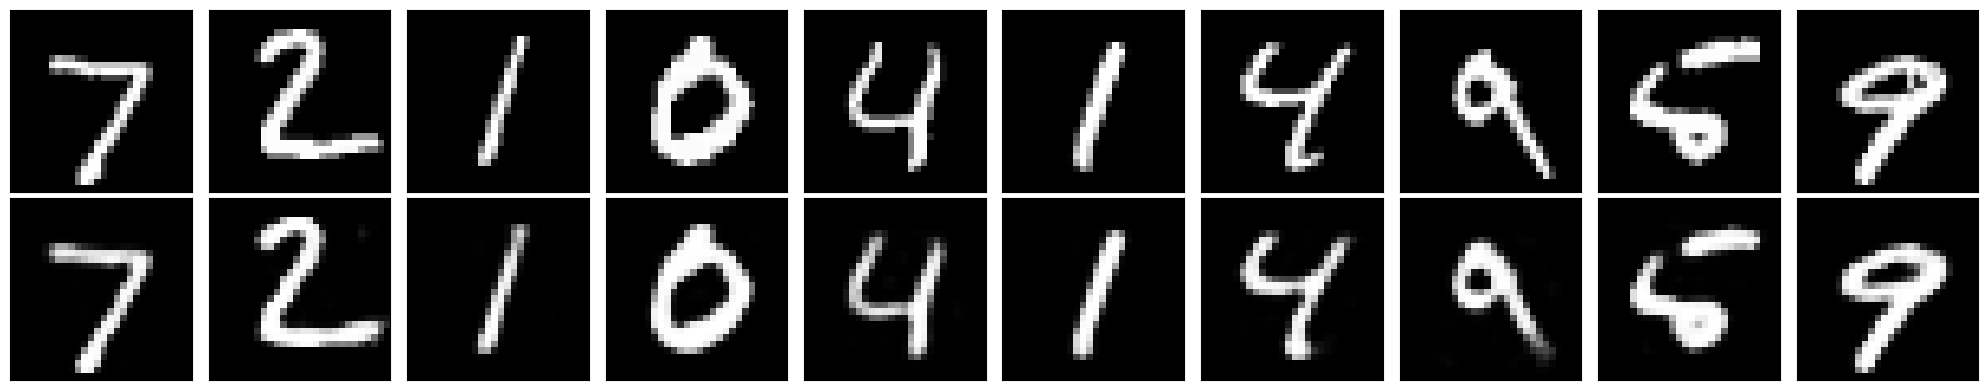

In [30]:
image_show(mnist_x_testMLP, decoded_imgs)

## Автокодировщик со слоями с $(784,8,784)$ нейронами

При уменьшении количества нейронов в среднем слое качество реконструкции существенно падает:

In [31]:
autoencoder8, encoder8, decoder8 = create_autoencoders(8)
autoencoder8.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder8.fit(mnist_x_trainMLP, mnist_x_trainMLP,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(mnist_x_testMLP, mnist_x_testMLP),
                verbose = 1);

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.4459 - val_loss: 0.2463
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2367 - val_loss: 0.2059
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2023 - val_loss: 0.1898
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1887 - val_loss: 0.1825
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1823 - val_loss: 0.1790
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1797 - val_loss: 0.1770
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1774 - val_loss: 0.1749
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1757 - val_loss: 0.1734
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1744 - val_loss: 0.1721
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1735 - val_loss: 0.1710
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1722 - val_loss: 0.1701
Epoch 12/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

In [32]:
encoded_imgs = encoder8.predict(mnist_x_testMLP)
decoded_imgs = decoder8.predict(encoded_imgs)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


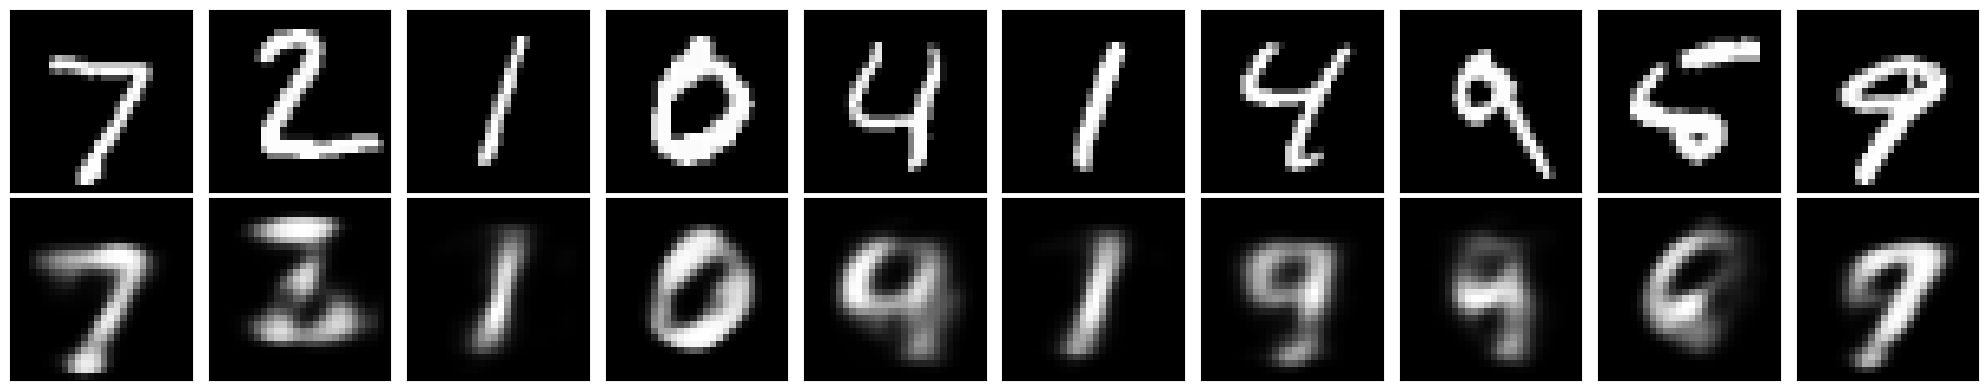

In [33]:
image_show(mnist_x_testMLP, decoded_imgs)

## Добавление ограничения разреженности

Еще один способ ограничить компактность представлений — добавить ограничение разреженности на активность скрытого представления, чтобы «срабатывало» меньшее количество нейронов. В Keras это можно сделать, добавив параметр `activity_regularizer` в плотный слой:

In [34]:
from keras import regularizers

encoding_dim = 16

input_img = Input(shape=(784,))

# плотный слой с регуляризатором активности L1 
encoded = Dense(encoding_dim, activation='relu',
    activity_regularizer=regularizers.l1(10e-5))(input_img)

decoded = Dense(784, activation='sigmoid')(encoded)

autoencoderL1 = Model(input_img, decoded)

In [35]:
autoencoderL1.compile(optimizer='adam', loss='binary_crossentropy')
autoencoderL1.fit(mnist_x_trainMLP, mnist_x_trainMLP,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(mnist_x_testMLP, mnist_x_testMLP),
                verbose = 1);

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.6764 - val_loss: 0.6155
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5987 - val_loss: 0.5535
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.5399 - val_loss: 0.5038
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.4927 - val_loss: 0.4638
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4547 - val_loss: 0.4314
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4239 - val_loss: 0.4050
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3988 - val_loss: 0.3834
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3781 - val_loss: 0.3656
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3613 - val_loss: 0.3508
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3471 - val_loss: 0.3385
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3354 - val_loss: 0.3281
Epoch 12/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

In [36]:
decoded_imgs = autoencoderL1.predict(mnist_x_testMLP)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


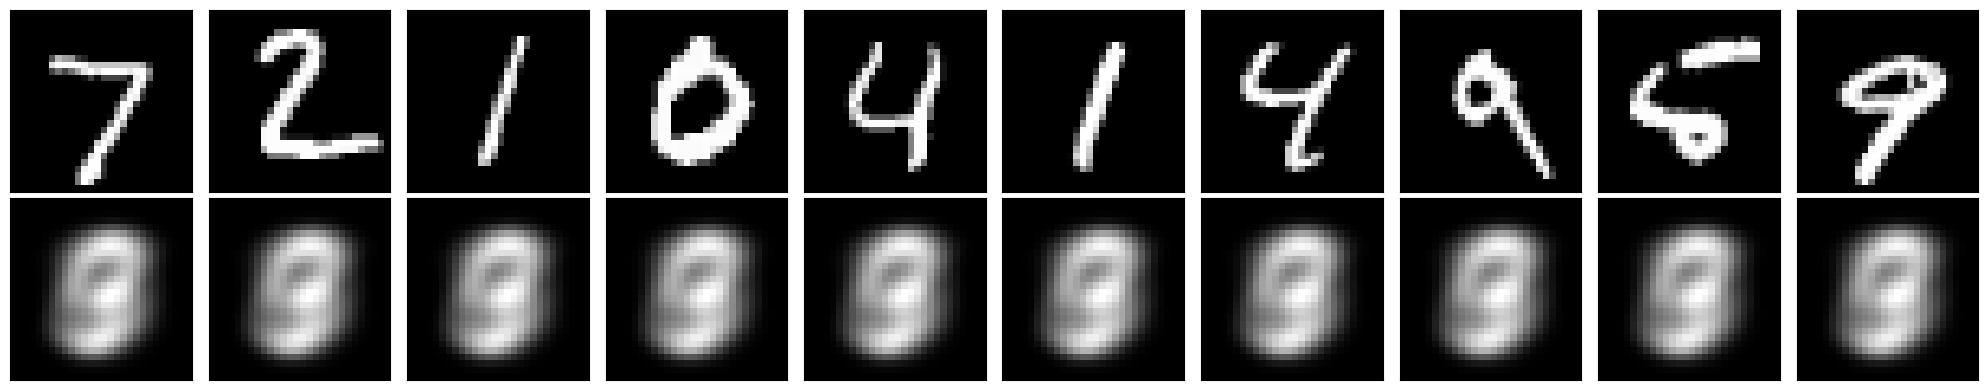

In [37]:
image_show(mnist_x_testMLP, decoded_imgs)

## Глубокий автокодировщик MLP

Вместо одного слоя в кодировщике и декодере можно использовать несколько слоев:

In [38]:
encoding_dim = 16

input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)
autoencoderD = Model(input_img, decoded)

In [39]:
#keras.utils.plot_model(autoencoderD, show_shapes=True)

In [40]:
autoencoderD.compile(optimizer='adam', loss='binary_crossentropy')

autoencoderD.fit(mnist_x_trainMLP, mnist_x_trainMLP,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(mnist_x_testMLP, mnist_x_testMLP),
                verbose = 1);

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.3527 - val_loss: 0.1906
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1769 - val_loss: 0.1520
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1499 - val_loss: 0.1407
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1400 - val_loss: 0.1346
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1348 - val_loss: 0.1301
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1303 - val_loss: 0.1271
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1271 - val_loss: 0.1235
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1236 - val_loss: 0.1208
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1213 - val_loss: 0.1179
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1185 - val_loss: 0.1162
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1166 - val_loss: 0.1152
Epoch 12/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 

## Сверточный автокодировщик

Поскольку входными данными являются изображения, имеет смысл использовать сверточные нейронные сети в качестве кодировщиков и декодеров. На практике автокодировщики, применяемые к изображениям, всегда являются сверточными автокодировщиками — они работают намного лучше.

Кодировщик будет состоять из стека слоев `Conv2D` и `MaxPooling2D` (максимальный пул используется для пространственной понижающей дискретизации), а декодер будет состоять из стека слоев `Conv2D` и `UpSampling2D`.

In [41]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,UpSampling2D

input_img = keras.Input(shape=(28, 28, 1))

x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

# Здесь представление (4, 4, 8) т.е. 128-мерное

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoderCNN = Model(input_img, decoded)

In [42]:
autoencoderCNN.compile(optimizer='adam', loss='binary_crossentropy')

In [43]:
mnist_x_train.shape, mnist_x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [44]:
mnist_x_trainCNN = mnist_x_train.reshape(
    (len(mnist_x_train), 28, 28, 1))
mnist_x_testCNN  = mnist_x_test.reshape(
    (len(mnist_x_test), 28, 28, 1))
mnist_x_trainCNN.shape, mnist_x_testCNN.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [45]:
autoencoderCNN.fit(mnist_x_trainCNN, mnist_x_trainCNN,
                epochs=5,
                batch_size=256,
                shuffle=True,
                validation_data=(mnist_x_testCNN, mnist_x_testCNN),
                verbose = 1);

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - loss: 0.3905 - val_loss: 0.1745
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - loss: 0.1649 - val_loss: 0.1432
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - loss: 0.1407 - val_loss: 0.1305
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - loss: 0.1297 - val_loss: 0.1236
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - loss: 0.1238 - val_loss: 0.1196


In [46]:
#keras.utils.plot_model(autoencoderCNN, show_shapes=True)

In [47]:
decoded_imgs = autoencoderCNN.predict(mnist_x_testCNN)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


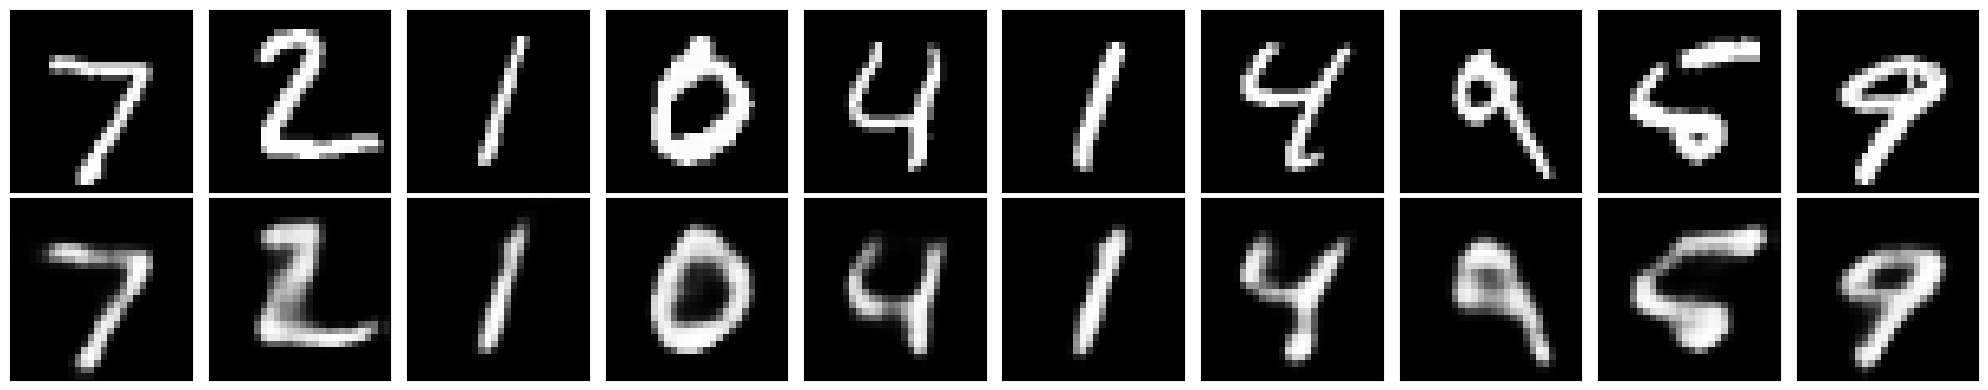

In [48]:
image_show(mnist_x_testCNN, decoded_imgs)

## Классификация по латентным признакам

Проверим, как можно использовать скрытые (латентные) признаки или, другими словами, выходные данные среднего слоя, чтобы выполнить классификацию объектов. Что происходит с точностью и производительностью алгоритмов? Проверим несколько примеров.

### Алгоритм kNN (метод ближайших соседей)

Первым протестируем алгоритм kNN из библиотеки ```sklearn```.

In [49]:
encoded_train_imgs = encoder8.predict(mnist_x_trainMLP)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 548us/step


Обратите внимание, что переменная ```encoded_train_imgs``` имеет только 8 признаков (последний обученный нами автокодировщик имел только 8 нейронов в среднем слое). В исходном наборе данных было 784 признаков (оттенки серого в пикселях изображений).

In [50]:
encoded_train_imgs.shape

(60000, 8)

In [51]:
def plot_confusion_matrix(data, labels, output_filename):
    """Визуализация матрицы ошибок при помощи heatmap
 
    Аргументы:
        data (список списков): матрица ошибок (confusion matrix)
        labels (список): Метки для осей x и y
        output_filename (текст): Путь к выходному файлу
 
    """
    sns.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
 
    sns.set(font_scale=1.3)
    ax = sns.heatmap(data, annot=True, cmap="Blues", 
                     cbar_kws={'label': 'Шкала'},fmt='d')
 
    ax.set_xticklabels(labels, fontsize = 16)
    ax.set_yticklabels(labels, fontsize = 16)
 
    ax.set_xlabel("Прогнозные метки", fontsize = 16)
    ax.set_ylabel("Истинные метки", fontsize = 16)
 
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

In [52]:
# импорт необходимых библиотек 
from sklearn import datasets 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
import seaborn as sns

Обучим классификатор на закодированных изображениях и измерим, сколько времени потребуется для обучения. Позже сделаем то же самое с исходным набором данных и сравним результаты и время выполнения.

In [53]:
start = time.time()
 
# обучаем классификатор KNN 
from sklearn.neighbors import KNeighborsClassifier 

knn = KNeighborsClassifier(n_neighbors=7).fit(encoded_train_imgs, 
                                              mnist_y_train) 
  
# доля верных ответов на X_test 
accuracy = knn.score(encoded_imgs, mnist_y_test) 
print (accuracy )

end = time.time()
print("Время работы",end - start,"сек.") 


0.8966
Время работы 1.0749785900115967 сек.


Всего с 8 признаками получаем 89% точности за несколько секунд.

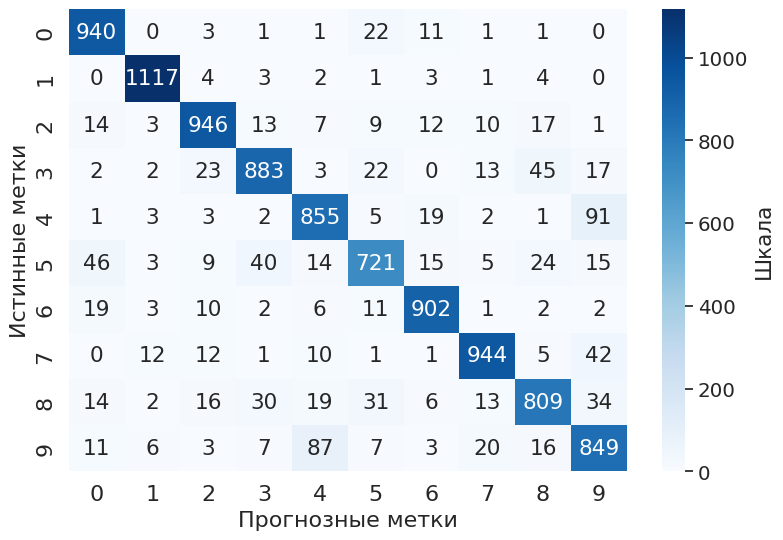

In [54]:
# строим матрицу ошибок 
knn_predictions = knn.predict(encoded_imgs)  

cm = confusion_matrix(mnist_y_test, knn_predictions)

plot_confusion_matrix(cm, [0,1,2,3,4,5,6,7,8,9], 
                      "confusion_matrix.png")

### Алгоритм kNN со всеми признаками

Теперь давайте обучим классификатор со всеми 784 признаками.

In [55]:
start = time.time()
 
knn2 = KNeighborsClassifier(n_neighbors = 7).fit(
    mnist_x_trainMLP, mnist_y_train) 

# доля верных ответов на X_test 
accuracy = knn2.score(mnist_x_testMLP, mnist_y_test)  
print (accuracy )

end = time.time()
print("Время работы",end - start,"sec.") 

0.9694
Время работы 9.938029050827026 sec.


Со всеми признаками получаем точность 96% (на 7% больше, чем с 8 признаками), но это занимает больше времени. Для большого набора данных разница может быть гораздо более существенной.

## Функция потерь MSE

Автокодировщики настолько гибки, что работают, даже если мы используем в качестве функции потерь MSE. 

In [56]:
dim = 16

input_img = Input(shape = (784,))
encoded = Dense(dim, activation = 'relu')(input_img)
decoded = Dense(784, activation = 'sigmoid')(encoded)

autoencoderMSE = Model(input_img, decoded)
encoderMSE = Model(input_img, encoded)

In [57]:
encoded_input = Input(shape = (dim,))
decoder = autoencoderMSE.layers[-1]
decoderMSE = Model(encoded_input, decoder(encoded_input))

In [58]:
autoencoderMSE.compile(optimizer='adam', loss='mse')

In [59]:
autoencoderMSE.fit(mnist_x_trainMLP, mnist_x_trainMLP,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(mnist_x_testMLP, mnist_x_testMLP),
                verbose = 1);

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1187 - val_loss: 0.0504
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0466 - val_loss: 0.0385
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0372 - val_loss: 0.0323
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0316 - val_loss: 0.0286
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0284 - val_loss: 0.0266
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0267 - val_loss: 0.0256
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0259 - val_loss: 0.0248
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0250 - val_loss: 0.0242
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0245 - val_loss: 0.0237
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0240 - val_loss: 0.0232
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0235 - val_loss: 0.0228
Epoch 12/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [60]:
encoded_imgs = encoderMSE.predict(mnist_x_testMLP)
decoded_imgs = decoderMSE.predict(encoded_imgs)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step


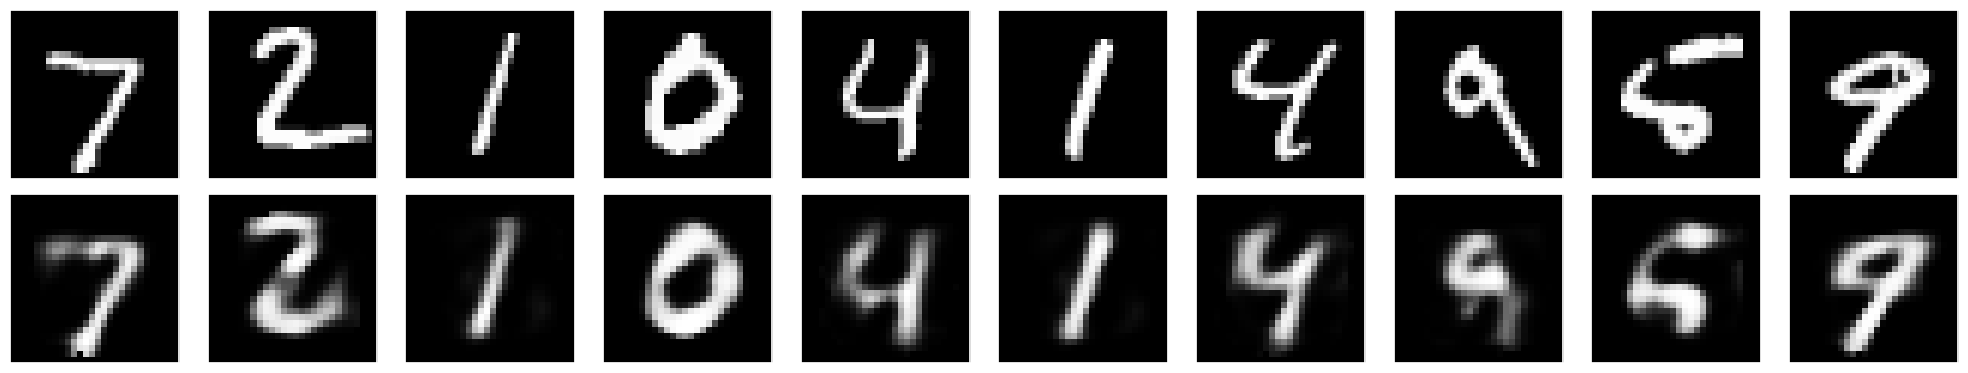

In [61]:
image_show(mnist_x_testMLP, decoded_imgs)

## Набор данных Fashion MNIST

Используем автокодировщик с 8 нейронами в среднем слое с набором данных FASHION MNIST.

In [62]:
autoencoder8, encoder8, decoder8 = create_autoencoders(8)
autoencoder8.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder8.fit(fashion_x_trainMLP, fashion_x_trainMLP,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(fashion_x_testMLP, fashion_x_testMLP),
                verbose = 1);

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5464 - val_loss: 0.3947
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3832 - val_loss: 0.3589
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3523 - val_loss: 0.3398
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3354 - val_loss: 0.3322
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3294 - val_loss: 0.3274
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3245 - val_loss: 0.3240
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3208 - val_loss: 0.3215
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3191 - val_loss: 0.3198
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3184 - val_loss: 0.3188
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3169 - val_loss: 0.3180
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3158 - val_loss: 0.3175
Epoch 12/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

In [63]:
encoded_imgs = encoder8.predict(fashion_x_testMLP)
decoded_imgs = decoder8.predict(encoded_imgs)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step


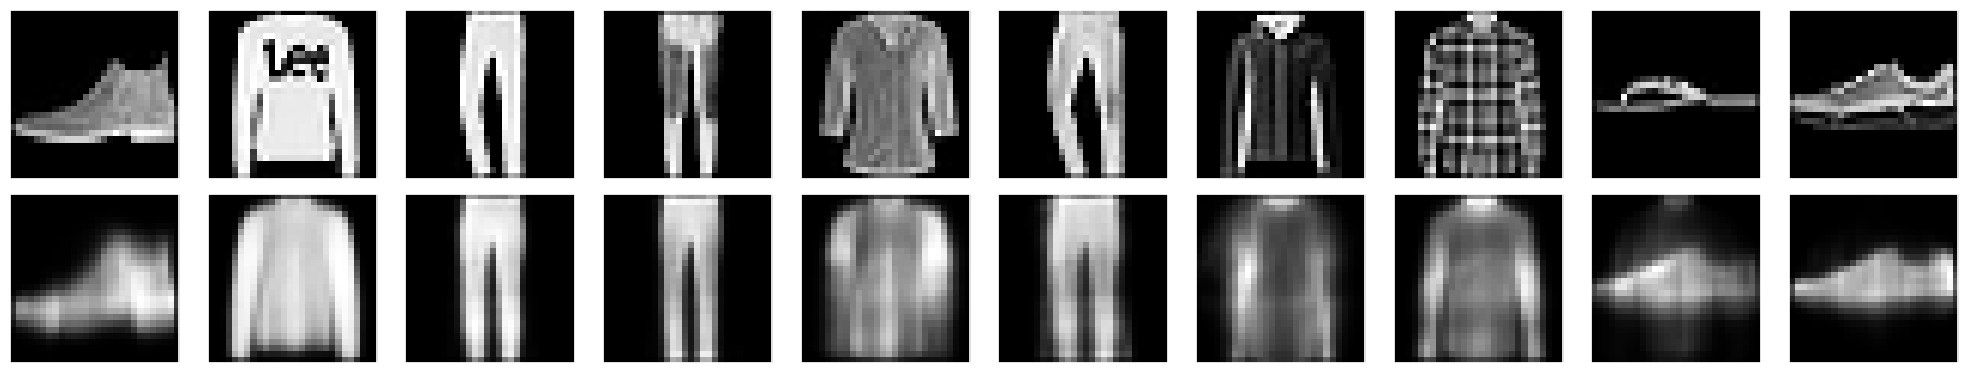

In [64]:
image_show(fashion_x_testMLP, decoded_imgs)

Снова построим классификатор со всеми данными:

In [65]:
start = time.time()

knn = KNeighborsClassifier(n_neighbors = 7).fit(
    fashion_x_trainMLP, fashion_y_train) 

# Доля верных ответов на X_test 
accuracy = knn.score(fashion_x_testMLP, fashion_y_test) 
print (accuracy )

end = time.time()
print(end - start)

0.854
11.021817684173584


## Алгоритм kNN на обученном представлении

In [66]:
encoded_fashion_train_imgs = encoder8.predict(fashion_x_trainMLP)
encoded_fashion_test_imgs = encoder8.predict(fashion_x_testMLP)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step


In [67]:
start = time.time()
 
# обучаем классификатор KNN 
knn = KNeighborsClassifier(n_neighbors = 7).fit(
    encoded_fashion_train_imgs, fashion_y_train) 
  
# доля верных ответов на X_test 
accuracy = knn.score(encoded_fashion_test_imgs, fashion_y_test) 
print (accuracy )

end = time.time()
print(end - start)

0.7966
0.9096419811248779


Опять теряем около 5% доли верных ответов за счет существенного ускорения работы. 

## Доля верных ответов для kNN с автокодировщиком с количеством нейронов $(784,16,784)$

In [68]:
autoencoder16, encoder16, decoder16 = create_autoencoders(16)
autoencoder16.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder16.fit(fashion_x_trainMLP, fashion_x_trainMLP,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(fashion_x_testMLP, fashion_x_testMLP),
                verbose = 1);

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5226 - val_loss: 0.3664
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3536 - val_loss: 0.3333
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3269 - val_loss: 0.3214
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3173 - val_loss: 0.3143
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3107 - val_loss: 0.3095
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3059 - val_loss: 0.3063
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3037 - val_loss: 0.3044
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3015 - val_loss: 0.3032
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3007 - val_loss: 0.3021
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2998 - val_loss: 0.3017
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2990 - val_loss: 0.3011
Epoch 12/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

In [69]:
encoded_fashion_train_imgs = encoder16.predict(fashion_x_trainMLP)
encoded_fashion_test_imgs = encoder16.predict(fashion_x_testMLP)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 547us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step


In [70]:
start = time.time()
 
# обучение классификатора KNN 
knn = KNeighborsClassifier(n_neighbors = 7).fit(
    encoded_fashion_train_imgs, fashion_y_train) 
  
# доля верных ответов на X_test 
accuracy = knn.score(encoded_fashion_test_imgs, fashion_y_test) 
print (accuracy )

end = time.time()
print(end - start)

0.837
0.6288816928863525


Увеличение количества нейронов в среднем слое до 16 увеличивает долю верных ответов при незначительном увеличении времени работы.

## Обнаружение аномалий при помощи автокодировщиков

Разберемся, что означает обнаружение аномалий. Создадим специальный набор данных, состоящий из 10000 изображений тестового набора данных MNIST и одного изображения из набора данных Fashion MNIST. Нашей целью будет найти это изображение автоматически. 

In [71]:
x_test = np.concatenate((mnist_x_testMLP, 
                         fashion_x_testMLP[0].reshape(1,784)))
x_test.shape

(10001, 784)

Все изображения в наборе данных MNIST представляют собой написанные от руки цифры. Ниже вы можете увидеть пример одного из них.

In [72]:
def mnist_show(img):
    plt.gray()
    plt.tick_params(axis = 'x', which = 'both', bottom = False, 
                    top = False, labelbottom = False) 
    plt.tick_params(axis = 'y', which = 'both', left = False, 
                    right = False, labelleft = False)

    plt.imshow(img.reshape(28, 28))    

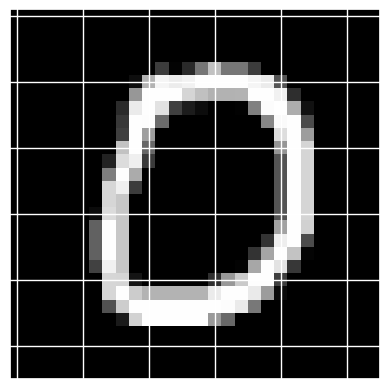

In [73]:
mnist_show(mnist_x_test[10]);

Но изображения в Fashion MNIST — это все изображения оттенками серого предметов одежды. В частности, мы добавляем к рукописным цифрам изображение обуви, которое можно увидеть ниже.

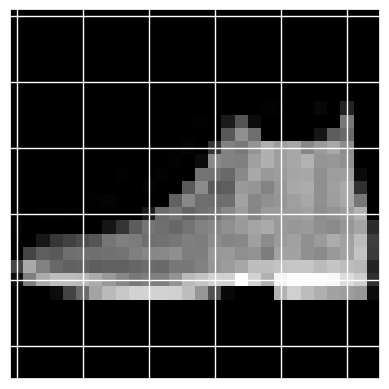

In [74]:
mnist_show(fashion_x_test[0]);

## Автокодировщик со слоями с $(784,64,784)$  нейронами

In [75]:
autoencoder64, encoder64, decoder64 = create_autoencoders(64)

In [76]:
#keras.utils.plot_model(autoencoder64, show_shapes = True)

In [77]:
autoencoder64.compile(optimizer = 'adam', loss = 'binary_crossentropy')

In [78]:
history = autoencoder64.fit(mnist_x_trainMLP, mnist_x_trainMLP,
                          epochs = 30,
                          batch_size = 256,
                          shuffle = True,
                          validation_data = (mnist_x_testMLP, mnist_x_testMLP),
                          verbose = 1)

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3489 - val_loss: 0.1625
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1523 - val_loss: 0.1248
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1212 - val_loss: 0.1070
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1054 - val_loss: 0.0963
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0956 - val_loss: 0.0894
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0889 - val_loss: 0.0846
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0846 - val_loss: 0.0813
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0815 - val_loss: 0.0791
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0795 - val_loss: 0.0774
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0777 - val_loss: 0.0763
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0768 - val_loss: 0.0755
Epoch 12/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

In [79]:
encoded_imgs = encoder64.predict(x_test)
decoded_imgs = decoder64.predict(encoded_imgs)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step


Теперь мы можем рассчитать ошибку реконструкции ($\textrm{RE}^{[j]}$) изображения $j$, просто вычислив

$$
\textrm{RE}^{[j]} = \sum_{i=1}^{784}\frac{(x_i^{[j]}-x_{rec,i}^{[j]})^2}{m}
$$

где $x_i^{[j]}$ — это значение $i^{го}$ пикселя изображения $j$, а сумма вычисляется по всем пикселям.

In [80]:
RE = ((x_test - decoded_imgs)**2).mean(axis = 1)
RE_original = RE.copy()

Ошибка реконструкции $\textrm{RE}$ для изображения обуви, которое мы добавили, может быть легко выведена, так как это последний элемент вектора ```RE```.

In [81]:
RE[-1]

0.058398847

Легко видеть, что это самая высокая ошибка реконструкции $\textrm{RE}$, которая у нас есть для всех 10000 изображений. Мы можем проверить это, отсортировав вектор ```RE```.

In [82]:
RE.shape

(10001,)

In [83]:
RE.sort()
print(RE[9990:])

[0.01691641 0.01715102 0.01717144 0.01717875 0.01723984 0.01730762
 0.01761419 0.01799937 0.01813137 0.01868533 0.05839885]


Вы можете видеть, что вторая по величине ошибка реконструкции составляет менее половины $\textrm{RE}$ для добавленного изображения. Ниже вы можете увидеть исходное изображение и то, которое реконструировал обученный автокодировщик. Вы можете видеть, что восстановленное изображение совсем не похоже на оригинал.

### Самая большая ошибка реконструкции RE

In [84]:
biggest_re_pos = np.argmax(RE_original)

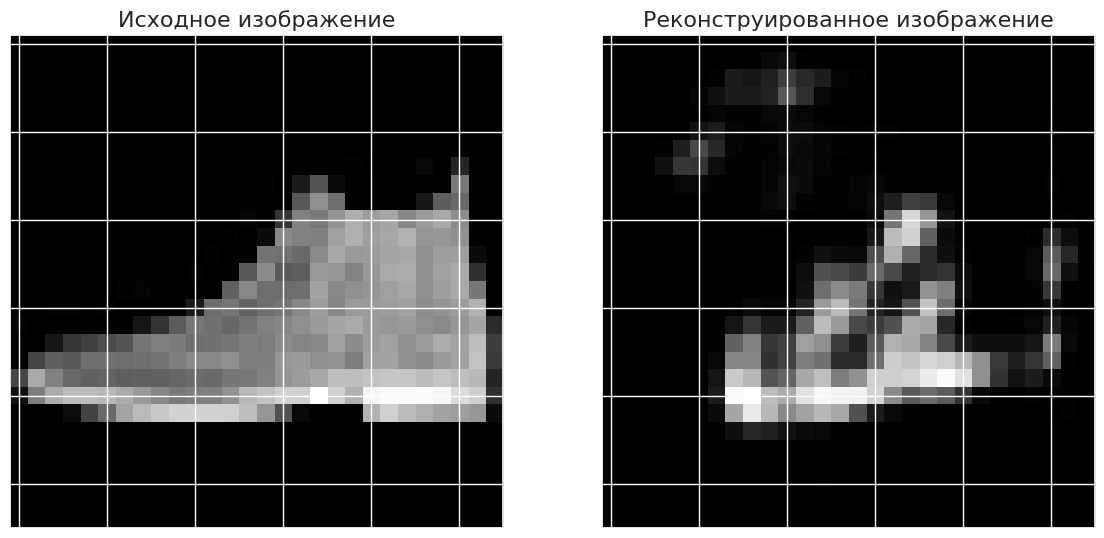

In [85]:
fig = plt.figure(figsize = (14, 7))

ax = fig.add_subplot(1, 2, 1)
plt.title('Исходное изображение', fontsize = 16)
mnist_show(x_test[biggest_re_pos])

ax = fig.add_subplot(1, 2, 2)
plt.title('Реконструированное изображение', fontsize = 16)
mnist_show(decoded_imgs[biggest_re_pos]);

Как вы можете видеть ниже, автокодировщик способен идеально реконструировать рукописные изображения цифр.

### Вторая по величине ошибка реконструкции RE

Изображение, показанное ниже (и его реконструированная версия), имеет вторую по величине ошибку реконструкции. Причина ясна, это изображение совсем не похоже на рукописную цифру! Это может даже считаться выбросом в наборе данных.

In [86]:
second_biggest_re_pos = list(RE_original).index(RE[-2])

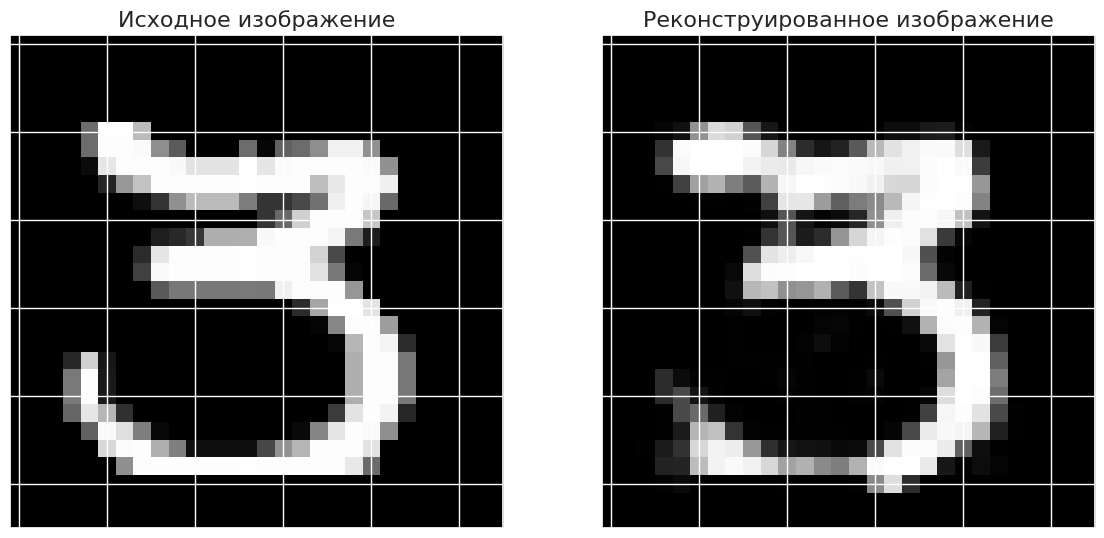

In [87]:
fig = plt.figure(figsize = (14, 7))

ax = fig.add_subplot(1, 2, 1)
plt.title('Исходное изображение', fontsize = 16)
mnist_show(x_test[second_biggest_re_pos])

ax = fig.add_subplot(1, 2, 2)
plt.title('Реконструированное изображение', fontsize = 16)
mnist_show(decoded_imgs[second_biggest_re_pos]);

### Третья по величине ошибка реконструкции RE

In [88]:
third_biggest_re_pos = list(RE_original).index(RE[-3])

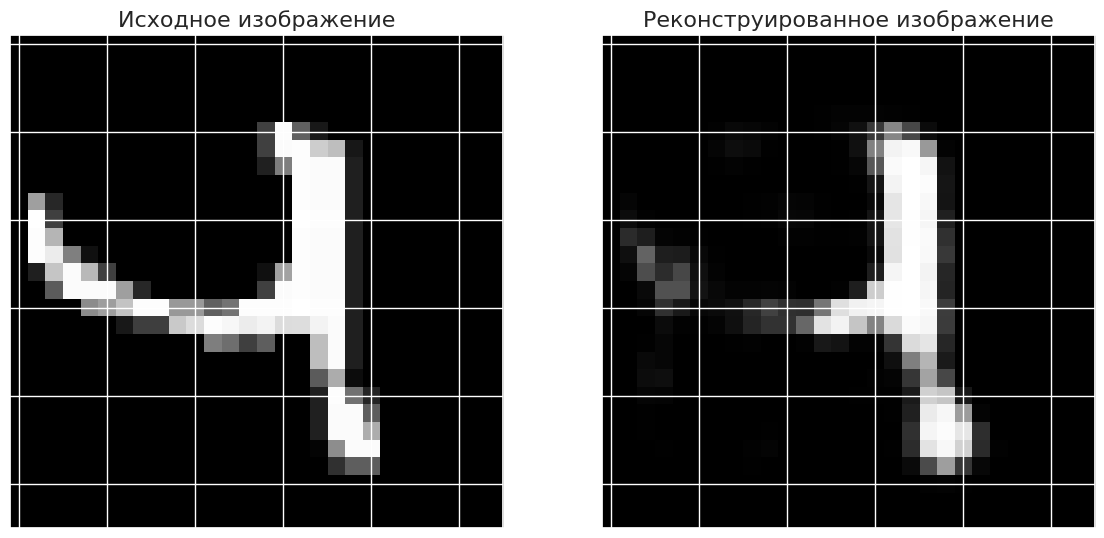

In [89]:
fig = plt.figure(figsize = (14, 7))

ax = fig.add_subplot(1, 2, 1)
plt.title('Исходное изображение', fontsize = 16)
mnist_show(x_test[third_biggest_re_pos])

ax = fig.add_subplot(1, 2, 2)
plt.title('Реконструированное изображение', fontsize = 16)
mnist_show(decoded_imgs[third_biggest_re_pos]);

## Подавление шумов изображений с помощью автокодировщиков на основе нейронных сетей MLP

Используем [набор данных MNIST](http://yann.lecun.com/exdb/mnist/). Импортируем его из `keras` при помощи [```tensorflow.keras.datasets```](https://www.tensorflow.org/api_docs/python/tf/keras/datasets).

In [90]:
# Загружаем набор данных MNIST
(input_train, target_train), (input_test, target_test) = \
    mnist.load_data()

Выполним типовую нормализацию:

In [91]:
# Переводим числа в тип float32
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Нормализуем данные
input_train = input_train / 255.
input_test = input_test / 255.

In [92]:
# Изменим форму для сетей MLP
input_trainMLP = input_train.reshape(
    (len(input_train), np.prod(input_train.shape[1:])))
input_testMLP = input_test.reshape(
    (len(input_test), np.prod(input_test.shape[1:])))

In [93]:
# Изменим форму для сетей CNN
img_width, img_height = 28, 28

input_trainCNN = input_train.reshape(
    input_train.shape[0], img_width, img_height, 1)
input_testCNN = input_test.reshape(
    input_test.shape[0], img_width, img_height, 1)
input_shapeCNN = (img_width, img_height, 1)

Построим пример изображения для каждого возможного класса (то есть цифр от 0 до 9).

In [94]:
from random import *

def get_random_element_with_label (data, lbls, lbl):
    """Возвращает массив numpy (с одним столбцом) 
    с экземплярами выбранной метки."""

    tmp = lbls == lbl
    subset = data[tmp.flatten(), :]
    return subset[randint(0, subset.shape[0]), :]

In [95]:
# Изменяем форму обучающего набора данных
input_example = input_train.reshape(60000, 784)

In [96]:
# Следующий код создает массив numpy, где в столбце 0 будет
# пример метки 0, в столбце 1 метки 1 и так далее.
labels_overview = np.empty([784, 10])
for i in range (0, 10):
    col = get_random_element_with_label(
        input_example, target_train, i)
    labels_overview[:,i] = col

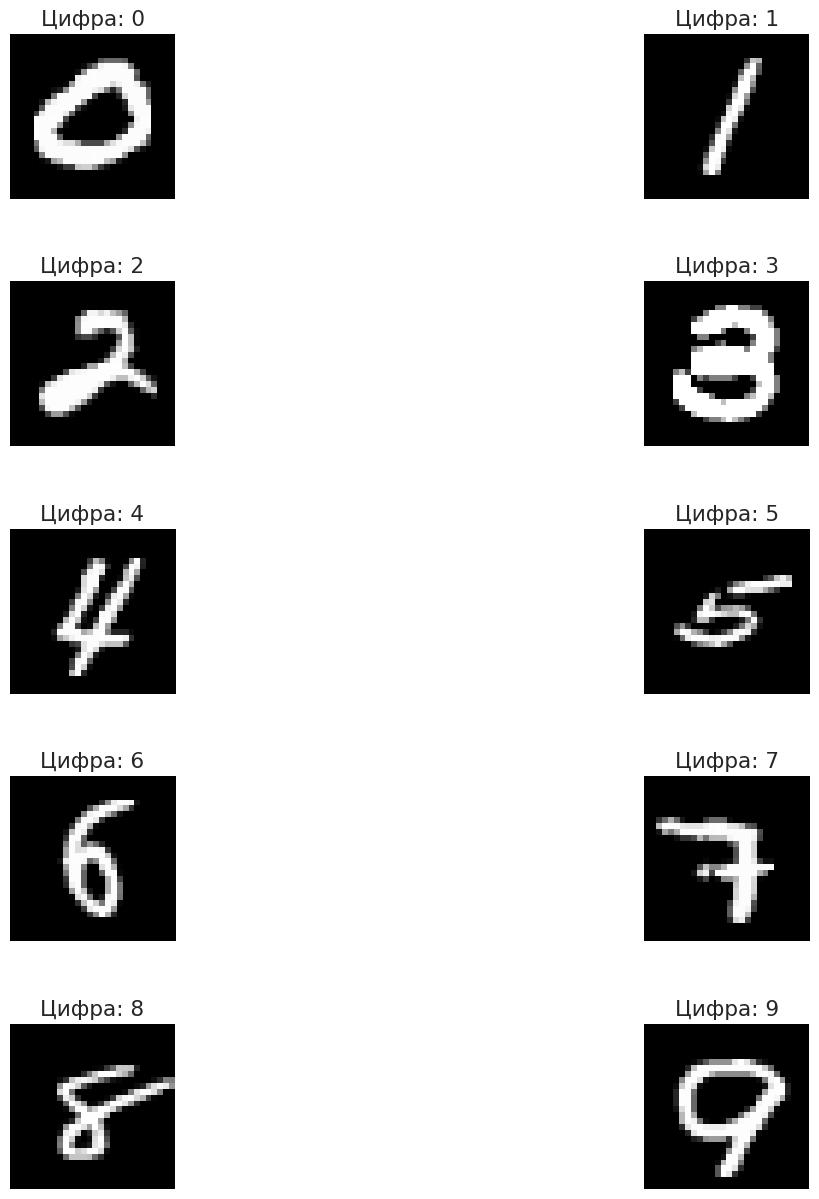

In [97]:
f = plt.figure(figsize = (15, 15))
count = 1
for i in range(0, 10):
    plt.gray()
    plt.subplot(5, 2, count)
    count = count + 1
    plt.subplots_adjust(hspace = 0.5)
    plt.title('Цифра: ' + str(i))
    some_digit_image = labels_overview[:, i]
    plt.imshow(some_digit_image.reshape(28, 28))
    plt.axis('off')
    pass

## Добавление шума в набор данных

Добавим источник шума к изображениям MNIST (с помощью функции `np.random.normal`), так как нашей целью будет удалить из них этот шум.

In [98]:
noise_factor = 0.55
pure = input_trainMLP
pure_test = input_testMLP
noise = np.random.normal(0, 1, pure.shape)
noise_test = np.random.normal(0, 1, pure_test.shape)
noisy_input = pure + noise_factor * noise
noisy_input_test = pure_test + noise_factor * noise_test

Теперь нарисуем несколько примеров изображений, искаженных шумом (по одному для каждого класса).

In [99]:
# Следующий код создает массив numpy, где в столбце 0 будет
# пример метки 0, в столбце 1 метки 1 и так далее.
labels_overview = np.empty([784, 10])
for i in range (0, 10):
    col = get_random_element_with_label(
        noisy_input, target_train, i)
    labels_overview[:,i] = col

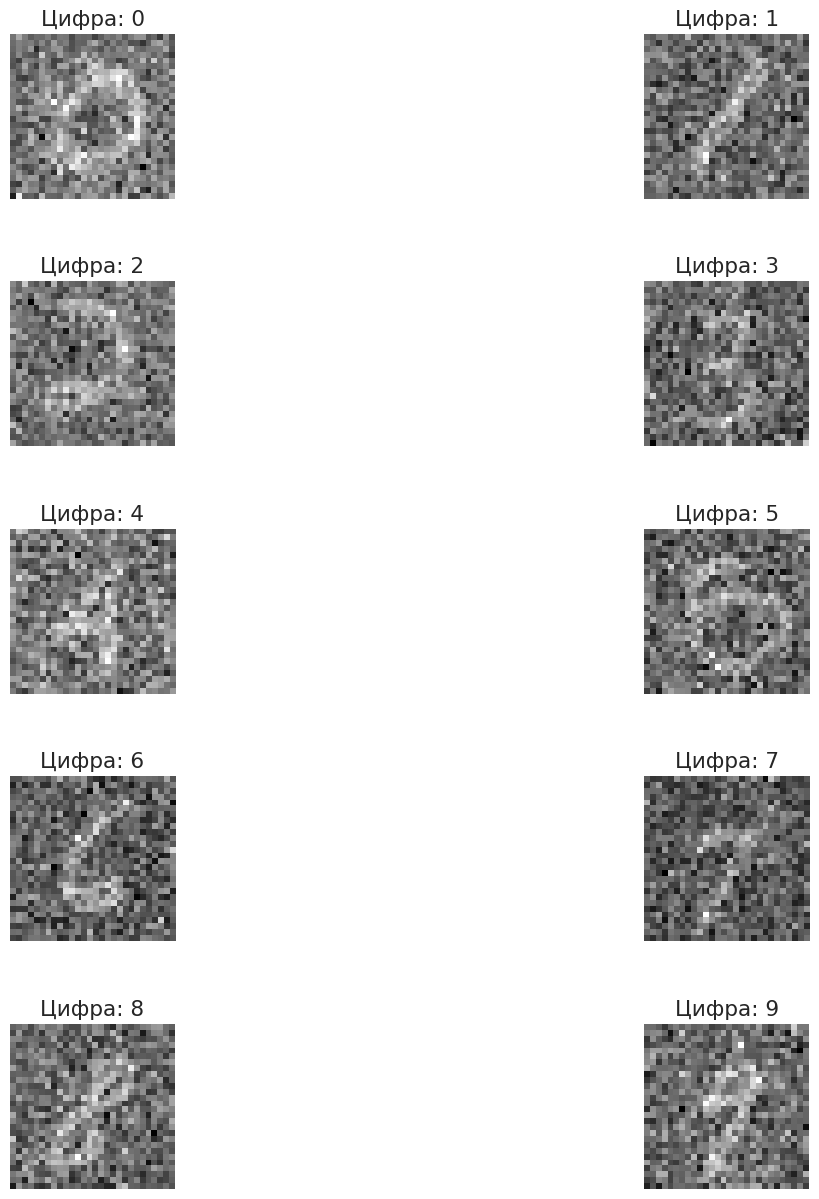

In [100]:
f = plt.figure(figsize = (15, 15))
count = 1
for i in range(0, 10):
    plt.gray()
    plt.subplot(5, 2, count)
    count = count + 1
    plt.subplots_adjust(hspace = 0.5)
    plt.title('Цифра: ' + str(i))
    some_digit_image = labels_overview[:, i]
    plt.imshow(some_digit_image.reshape(28, 28))
    plt.axis('off')
    pass

## Автокодировщик на базе сетей MLP

In [101]:
autoencoder32, encoder32, decoder32 = create_autoencoders(32) 

In [102]:
autoencoder32.summary()

Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoded_Features (Dense)        │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoded_Input (Dense)           │ (None, 784)            │        25,872 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,992 (199.19 KB)

 Trainable params: 50,992 (199.19 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:
#keras.utils.plot_model(autoencoder32, show_shapes = True)

Воспользуемся следующими параметрами для обучения модели:

In [104]:
batch_size = 150
no_epochs = 30
validation_split = 0.2

In [105]:
autoencoder32.compile(optimizer = 'adam', loss = 'binary_crossentropy')
autoencoder32.fit(noisy_input, pure,
                epochs = no_epochs,
                batch_size = batch_size,
                validation_split = validation_split);

Epoch 1/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3594 - val_loss: 0.1934
Epoch 2/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1849 - val_loss: 0.1654
Epoch 3/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1610 - val_loss: 0.1512
Epoch 4/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1485 - val_loss: 0.1437
Epoch 5/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1412 - val_loss: 0.1391
Epoch 6/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1368 - val_loss: 0.1361
Epoch 7/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1338 - val_loss: 0.1341
Epoch 8/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1323 - val_loss: 0.1329
Epoch 9/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1307 - val_loss: 0.1320
Epoch 10/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1299 - val_loss: 0.1316
Epoch 11/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1296 - val_loss: 0.1311
Epoch 12/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

## Примеры изображений с подавленным шумом

Построим несколько примеров изображений с подавленным шумом, сравнивая их с исходными чистыми изображениями, чтобы увидеть, насколько хорошо работает встроенный автокодировщик.

In [106]:
# Построим изображения без шума
number_of_visualizations = 6
samples = noisy_input_test[:number_of_visualizations]
targets = target_test[:number_of_visualizations]
denoised_images = autoencoder32.predict(samples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


<Figure size 640x480 with 0 Axes>

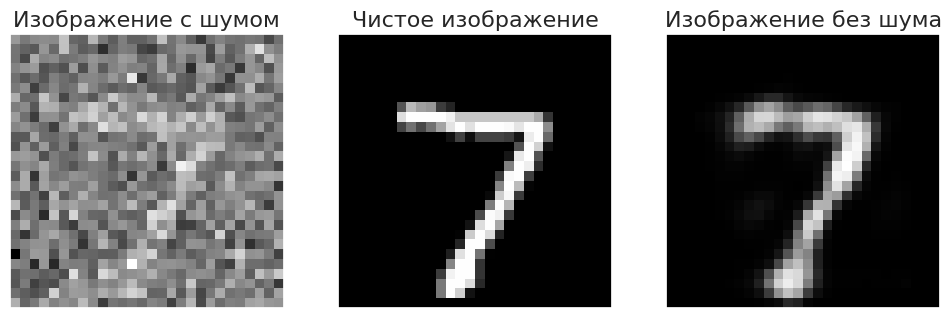

<Figure size 640x480 with 0 Axes>

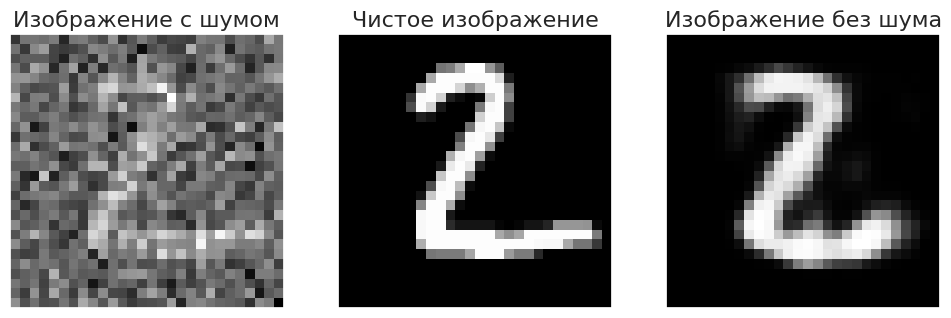

<Figure size 640x480 with 0 Axes>

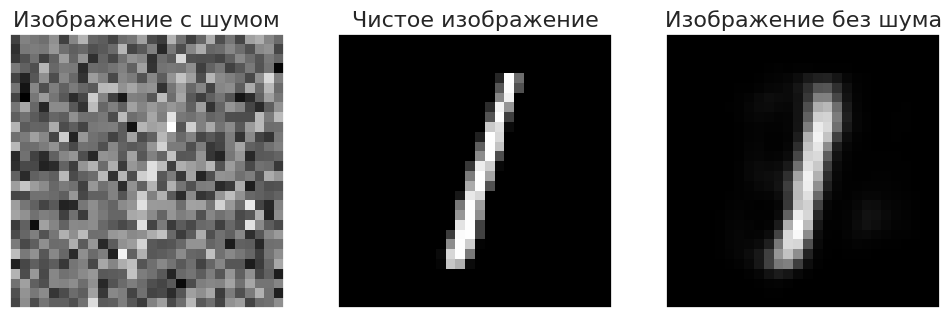

<Figure size 640x480 with 0 Axes>

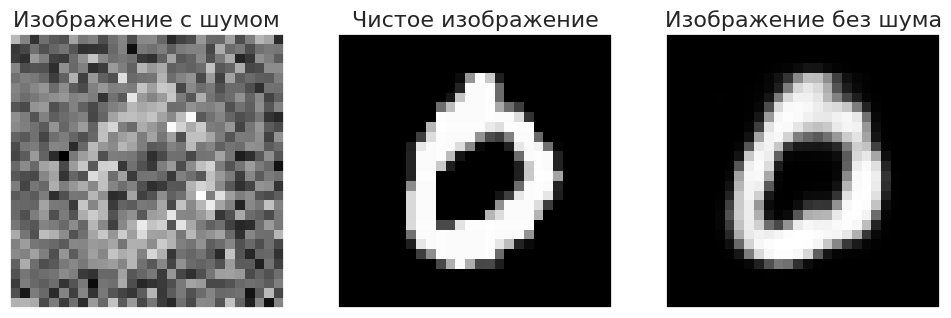

<Figure size 640x480 with 0 Axes>

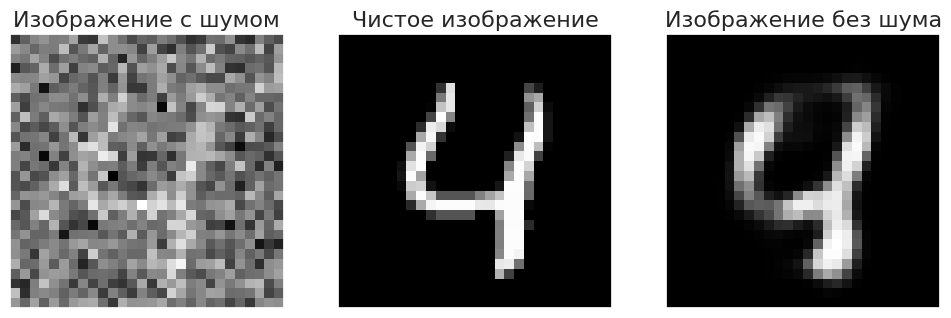

<Figure size 640x480 with 0 Axes>

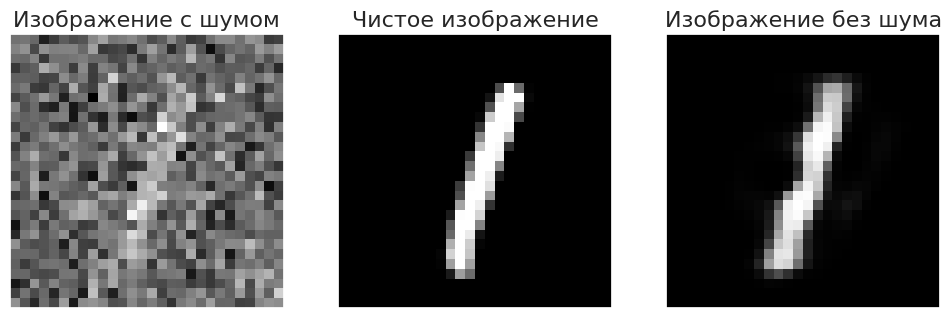

In [107]:
# нарисуем изображения без шума
for i in range(0, number_of_visualizations):
    plt.gray()
    # изображение и реконструкция
    noisy_image = noisy_input_test[i].reshape(28, 28)
    pure_image  = pure_test[i].reshape(28, 28)
    denoised_image = denoised_images[i].reshape(28, 28)
    input_class = targets[i]
    # подготовка
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(12, 7)
    # выводим изображение и реконструкцию
    axes[0].imshow(noisy_image)
    axes[0].set_title('Изображение с шумом', fontsize = 16)
    axes[0].get_xaxis().set_visible(False)
    axes[0].get_yaxis().set_visible(False)
    axes[1].imshow(pure_image)
    axes[1].set_title('Чистое изображение', fontsize = 16)
    axes[1].get_xaxis().set_visible(False)
    axes[1].get_yaxis().set_visible(False)
    axes[2].imshow(denoised_image)
    axes[2].set_title('Изображение без шума', fontsize = 16)
    axes[2].get_xaxis().set_visible(False)
    axes[2].get_yaxis().set_visible(False)
    plt.show()

Как видно из приведенного выше рисунка, построенная нами модель может реконструировать исходную версию изображений зашумленных цифр. Если у вас есть новые зашумленные изображения того же типа, вы можете применить к ним модель и удалить шум с тех же изображений.

## Автокодировщик с нейронной сетью CNN 

Функция ```create_autoencoder_CNN()``` ниже возвращает модель автокодировщика на базе CNN.

In [108]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.constraints import max_norm

def create_autoencoder_CNN(max_norm_value = 2.0):
    # Создаем модель
    model = Sequential()
    model.add(Conv2D(64, kernel_size = (3, 3), 
                     kernel_constraint = max_norm(max_norm_value), 
                     activation = 'relu', 
                     kernel_initializer = 'he_uniform', 
                     input_shape = input_shapeCNN))
    model.add(Conv2D(32, kernel_size = (3, 3), 
                     kernel_constraint = max_norm(max_norm_value), 
                     activation = 'relu', 
                     kernel_initializer = 'he_uniform'))
    model.add(Conv2DTranspose(32, kernel_size = (3,3), 
                     kernel_constraint = max_norm(max_norm_value), 
                     activation = 'relu', 
                     kernel_initializer = 'he_uniform'))
    model.add(Conv2DTranspose(64, kernel_size = (3,3), 
                     kernel_constraint = max_norm(max_norm_value), 
                     activation = 'relu', 
                     kernel_initializer = 'he_uniform'))
    model.add(Conv2D(1, kernel_size = (3, 3), 
                     kernel_constraint = max_norm(max_norm_value), 
                     activation = 'sigmoid', padding = 'same'))
    return model

In [109]:
model = create_autoencoder_CNN()

/home/gmatiukhin/Study/year3/ml-methods/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [110]:
#keras.utils.plot_model(model, show_shapes = True)

Для сети CNN нужна другая форма входных данных:

In [111]:
noisy_input = noisy_input.reshape(
    noisy_input.shape[0], img_width, img_height, 1)
pure = pure.reshape(
    pure.shape[0], img_width, img_height, 1)

noisy_input.shape,pure.shape

((60000, 28, 28, 1), (60000, 28, 28, 1))

Используем следующие параметры для обучения модели:

In [112]:
batch_size = 150
no_epochs = 5
validation_split = 0.2

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
model.fit(noisy_input, pure,
          epochs = no_epochs,
          batch_size = batch_size,
          validation_split = validation_split);

Epoch 1/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 100s 308ms/step - loss: 0.1733 - val_loss: 0.1066
Epoch 2/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 184s 440ms/step - loss: 0.1057 - val_loss: 0.1032
Epoch 3/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 134s 417ms/step - loss: 0.1023 - val_loss: 0.1014
Epoch 4/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 134s 418ms/step - loss: 0.1008 - val_loss: 0.1004
Epoch 5/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 145s 454ms/step - loss: 0.0998 - val_loss: 0.1006


## Примеры изображений с подавленным шумом

Построим несколько примеров изображений с подавленным шумом, сравнивая их с исходными чистыми изображениями, чтобы увидеть, насколько хорошо работает встроенный автокодировщик.

In [ ]:
noisy_input_test = noisy_input_test.reshape(
    noisy_input_test.shape[0], img_width, img_height, 1)
pure_test = pure_test.reshape(
    pure_test.shape[0], img_width, img_height, 1)

noisy_input_test.shape, pure_test.shape

In [ ]:
# Построим изображения без шума
number_of_visualizations = 6
samples = noisy_input_test[:number_of_visualizations]
targets = target_test[:number_of_visualizations]
denoised_images = model.predict(samples)

In [ ]:
for i in range(0, number_of_visualizations):
    plt.gray()
    
    noisy_image = noisy_input_test[i][:, :, 0]
    pure_image  = pure_test[i][:, :, 0]
    denoised_image = denoised_images[i][:, :, 0]
    input_class = targets[i]
    
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(12, 7)
    
    axes[0].imshow(noisy_image)
    axes[0].set_title('Noisy image', fontsize = 16)
    axes[0].get_xaxis().set_visible(False)
    axes[0].get_yaxis().set_visible(False)
    axes[1].imshow(pure_image)
    axes[1].set_title('Pure image', fontsize = 16)
    axes[1].get_xaxis().set_visible(False)
    axes[1].get_yaxis().set_visible(False)
    axes[2].imshow(denoised_image)
    axes[2].set_title('Denoised image', fontsize = 16)
    axes[2].get_xaxis().set_visible(False)
    axes[2].get_yaxis().set_visible(False)
    fig.suptitle(f'MNIST target = {input_class}')
    plt.show();

Как видно из приведенного выше рисунка, построенная нами модель может реконструировать исходную версию изображений зашумленных цифр. Если у вас есть новые зашумленные изображения того же типа, вы можете применить к ним модель и удалить шум с тех же изображений.

#### Задание (10 баллов)

Для закрепленного за Вами варианта работы:

1.	Загрузите заданный в индивидуальном задании набор данных с изображениями из Tensorflow Datasets с разбиением на обучающую и тестовую выборки. Оставьте в обучающей и тестовой выборках диапазон классов, указанных в индивидуальном задании. Если изображения цветные (с тремя каналами), то перекодируйте их в одноцветные (оттенки серого).
2.	Постройте для набора данных график логарифмического правдоподобия профиля в зависимости от числа главных компонент и определите размерность латентного пространства.
3.	Создайте и обучите на обучающей выборке автокодировщик архитектуры, указанной в индивидуальном задании, с размерностью скрытого представления, равной размерности латентного пространства, определенной в п.2. Подберите такие параметры, как функции активации, оптимизатор, начальная скорость обучения, размер мини-пакета и др. самостоятельно, обеспечивая обучение нейронных сетей. Визуализируйте несколько исходных и восстановленных автокодировщиком изображений. 
4.	Оцените качество модели автокодировщика на тестовой выборке по показателю, указанному в индивидуальном задании.
5.	Оставьте в наборах изображения первых двух классов диапазона, указанного в индивидуальном задании первыми. Визуализируйте набор данных на плоскости, соответствующей двум первым латентным признакам, отображая точки различных классов разными цветами. Подпишите оси и рисунок, создайте легенду для классов набора данных.
6.	Выполните бинарную классификацию изображений по латентным (скрытым) признакам и всем признакам при помощи классификатора метода ближайших соседей (kNN). Оцените долю верных ответов (accuracy) для двух построенных классификаторов
7.	Визуализируйте ROC-кривые для построенных классификаторов на одном рисунке (с легендой) (Указание: используйте метод predict_proba() класса KNeighborsClassifier).
8.	Визуализируйте границы принятия решений классификатора kNN для латентных признаков на плоскости, соответствующей двум первым латентным признакам (для прочих латентных признаков задайте средние/медианные значения). 
9.	Определите на первоначальной тестовой выборке изображение, имеющее наибольшую ошибку реконструкции. Выведите для этого изображения первоначальное и реконструированное изображения. 

